Using cuda:0 device


c:\Users\SirM\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SirM\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch 1/27, Training Loss: 0.5788426852952211, Validation Loss: 0.22768679910745376, Training Accuracy: 0.7885697067095219, Validation Accuracy: 0.9301204819277108
Epoch 2/27, Training Loss: 0.14295886855763504, Validation Loss: 0.07275794713925092, Training Accuracy: 0.96112896745681, Validation Accuracy: 0.9859437751004017
Epoch 3/27, Training Loss: 0.06280383141114353, Validation Loss: 0.03342183013088428, Training Accuracy: 0.9844314985938127, Validation Accuracy: 0.9911646586345382
Epoch 4/27, Training Loss: 0.03479752424531258, Validation Loss: 0.02302670010771507, Training Accuracy: 0.9919646444355162, Validation Accuracy: 0.9955823293172691
Epoch 5/27, Training Loss: 0.022873737797057495, Validation Loss: 0.014396765878280768, Training Accuracy: 0.9953796705504219, Validation Accuracy: 0.9963855421686747
Epoch 6/27, Training Loss: 0.018254757496134307, Validation Loss: 0.011710293913403383, Training Accuracy: 0.9961832061068703, Validation Accuracy: 0.99759

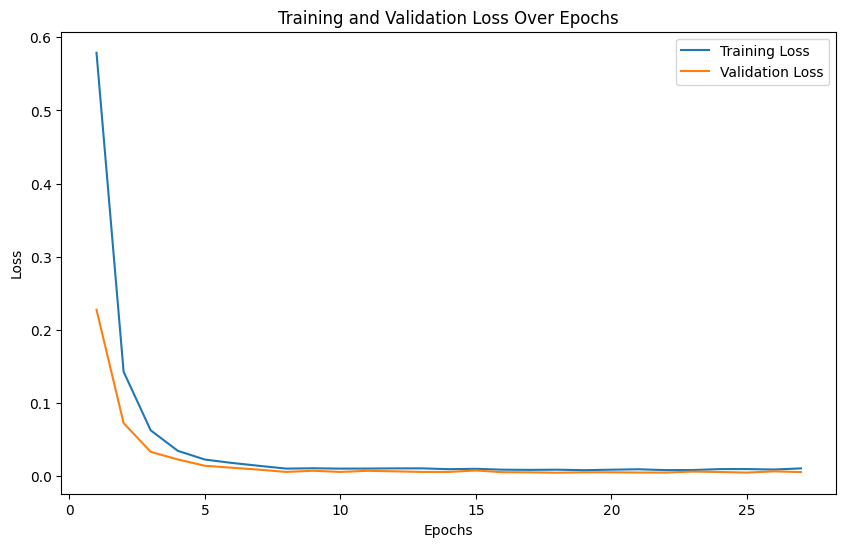

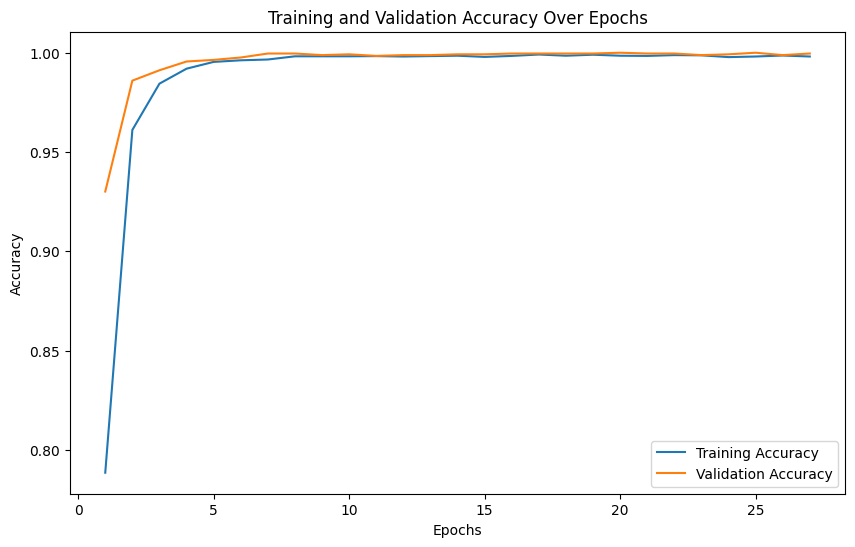

Evaluating model...
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
Classification Report:
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       779
      Normal       1.00      1.00      1.00      1001
       Stone       1.00      1.00      1.00       251
       Tumor       1.00      1.00      1.00       459

    accuracy                           1.00      2490
   macro avg       1.00      1.00      1.00      2490
weighted avg       1.00      1.00      1.00      2490



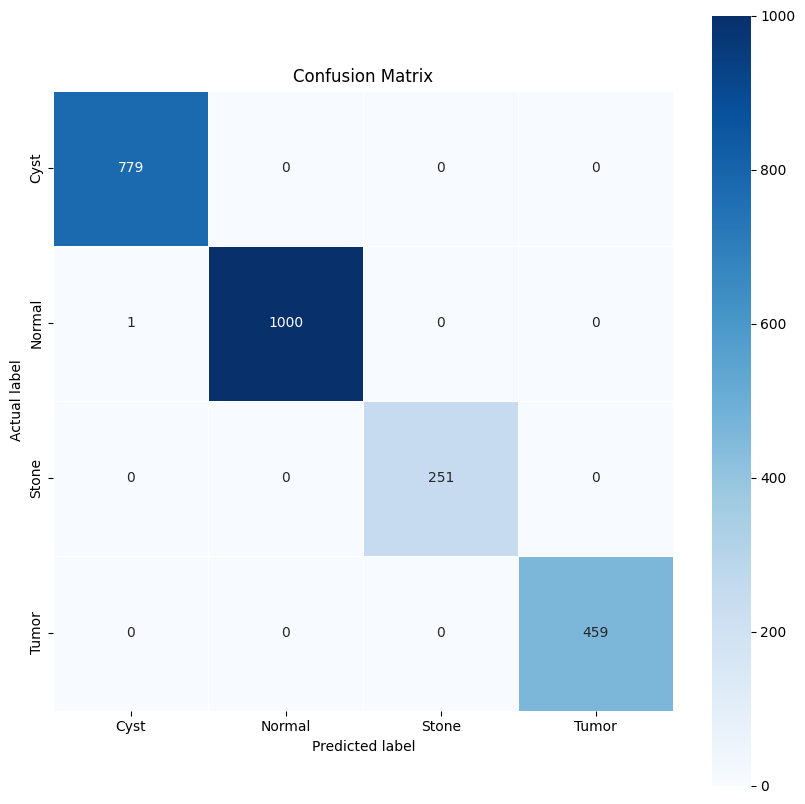

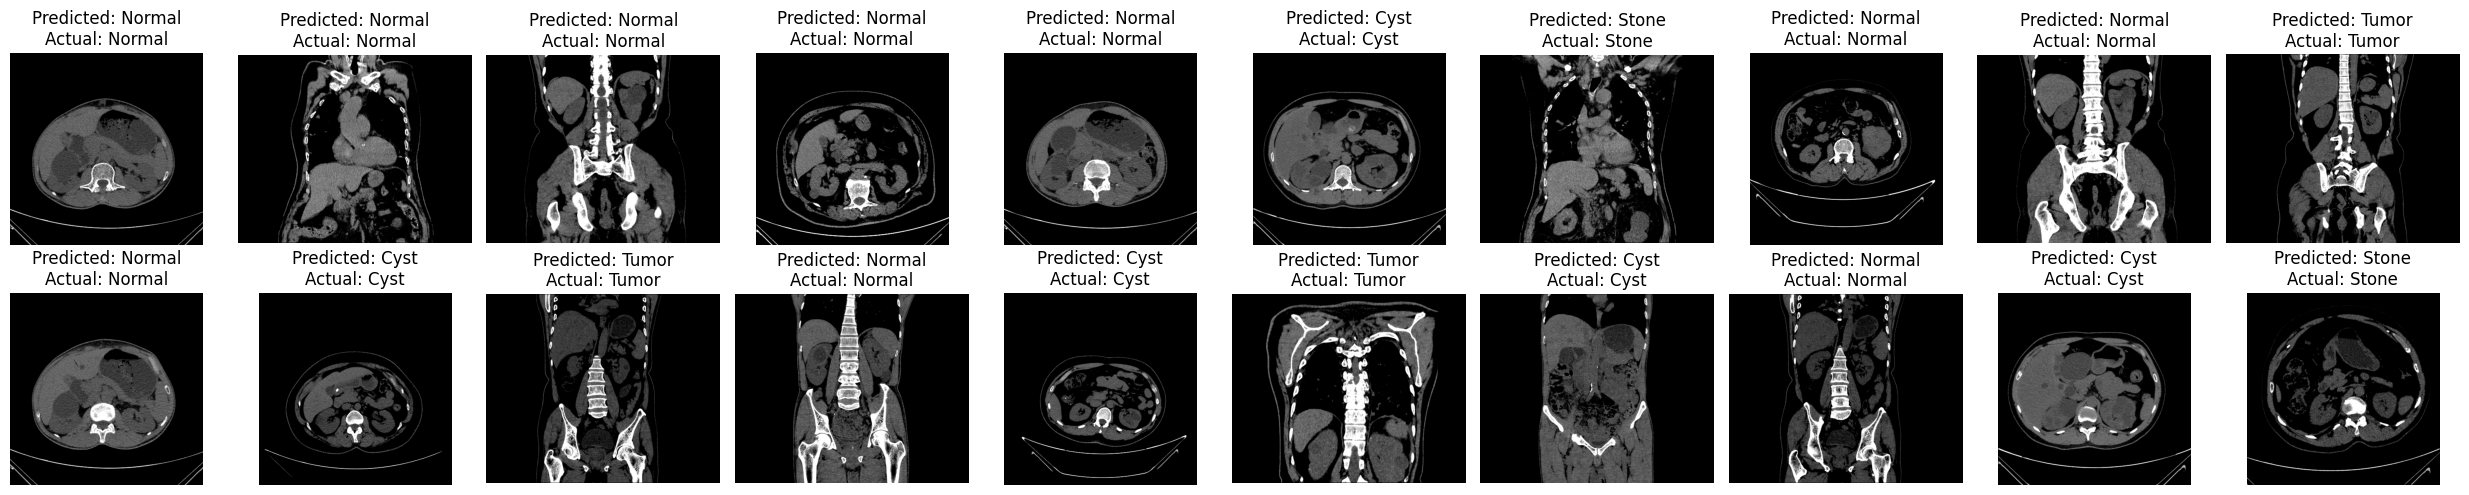

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import time
from PIL import Image
import random
from torchvision import models

# Set Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Enhanced Transformations with more augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Data
data_dir = "C:/Users/SirM/Downloads/archive (1)/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Calculate split sizes for 80-20 split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)

# Define the CNN Model
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

num_classes = len(full_dataset.classes)
model = ResNetModel(num_classes).to(device)

# Loss Function and Optimizer with L2 Regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Enhanced training loop with validation loss and accuracy tracking
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

print("Starting training...")
start_time = time.time()
num_epochs = 27

for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    train_loss = train_running_loss / len(train_loader)
    val_loss = val_running_loss / len(val_loader)
    train_acc = train_correct / train_total
    val_acc = val_correct / val_total

    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    training_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Training Accuracy: {train_acc}, Validation Accuracy: {val_acc}")

    # Learning Rate Scheduler Step
    scheduler.step()

end_time = time.time()
print(f"Finished Training in {end_time - start_time:.2f} seconds")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), training_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Evaluate the Model
print("Evaluating model...")
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and print metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Accuracy: {accuracy:.3f}")
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# Plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


def display_image_full_res(image_path, ax, pred_label, true_label):
    """Displays a full-resolution image with predicted and actual labels."""
    image = Image.open(image_path)
    ax.imshow(image)
    ax.set_title(f'Predicted: {pred_label}\nActual: {true_label}')
    ax.axis('off')

# Sample 20 random indices from the validation dataset
random_indices = random.sample(range(len(val_dataset)), 20)
sampled_images = [val_dataset[i][0] for i in random_indices]
sampled_labels = [val_dataset[i][1] for i in random_indices]

# Convert list of images to a batch tensor
sampled_images_tensor = torch.stack(sampled_images)
sampled_labels_tensor = torch.tensor(sampled_labels)

# Ensure model is in evaluation mode
model.eval()

# Get predictions using the resized images
outputs = model(sampled_images_tensor.to(device))
_, preds = torch.max(outputs, 1)

# Create a figure for displaying full-resolution images
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(25, 5))  # Adjust for 20 subplots
axes = axes.flatten()

# Display full-resolution images with predictions
for idx, label in enumerate(sampled_labels_tensor):
    # Get the file path for the full-resolution image
    image_path = full_dataset.samples[random_indices[idx]][0]
    true_label = full_dataset.classes[label.cpu().numpy()]
    pred_label = full_dataset.classes[preds[idx].cpu().numpy()]

    # Display the full-resolution image with prediction
    display_image_full_res(image_path, axes[idx], pred_label, true_label)

plt.tight_layout()
plt.show()